In [1]:
#!pip install --upgrade scikit-image

To install: [pyrwt](https://bitbucket.org/amitibo/pyrwt/src/default/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.linalg import norm, inv
from scipy.sparse.linalg import cg 
from scipy import misc
from numpy.fft import fft2, ifft2
from scipy.signal import convolve2d
import time

In [39]:
#from rwt import *
from rwt.wavelets import waveletCoeffs
from rwt import dwt, idwt, rdwt, irdwt

In [4]:
from skimage import data

Загрузим стандартное изображение *cameraman*

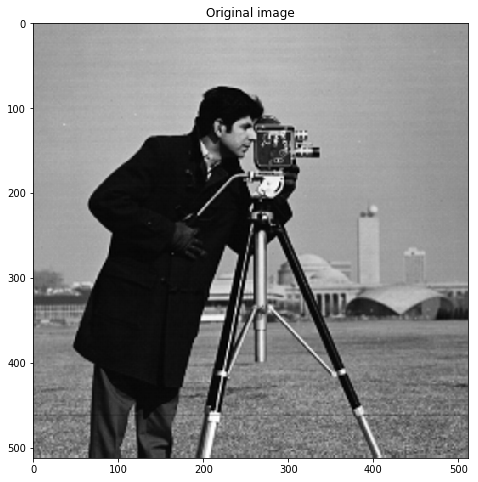

In [5]:
# load image
y0 = data.camera()
y0 = y0.astype(np.float64)

M, N = y0.shape

plt.figure(figsize=(8,8))
plt.imshow(y0, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Original image')
plt.show()

Изображение представлено двумерным массивом размером *height x width*, элементы которого находятся в диапазоне от 0 (черный) до 255 (белый).

Выведем на экран участок изображения:

In [6]:
print(y0[150:160, 200:210])

[[200. 217. 222. 225. 217. 181. 144. 126. 119. 116.]
 [194. 214. 219. 227. 225. 197. 164. 141. 127. 123.]
 [185. 208. 215. 227. 228. 194. 157. 144. 140. 134.]
 [171. 198. 207. 216. 213. 179. 146. 148. 157. 149.]
 [150. 179. 187. 170. 149. 143. 147. 160. 173. 170.]
 [121. 151. 160. 123.  89. 112. 149. 171. 186. 189.]
 [ 74.  98. 112.  99.  90. 115. 148. 171. 187. 192.]
 [ 34.  56.  80.  95. 108. 122. 138. 161. 181. 186.]
 [ 24.  70. 116. 120. 111.  95.  90. 123. 160. 171.]
 [ 25.  95. 160. 152. 120.  79.  55.  92. 139. 152.]]


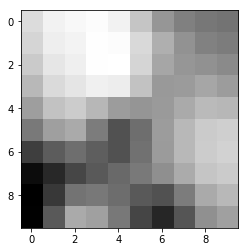

In [7]:
plt.imshow(y0[150:160, 200:210], cmap='gray')
plt.show()

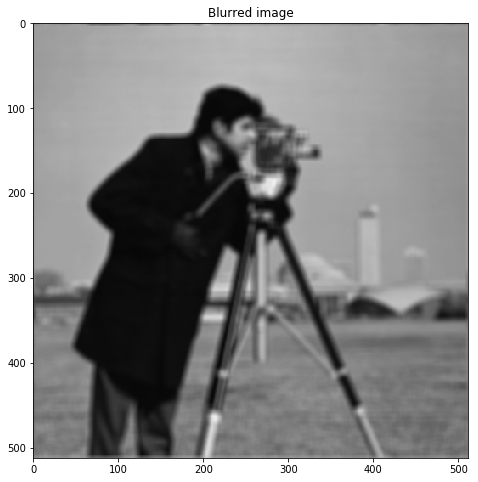

In [8]:
lh = 9

kernel = np.ones((lh, lh))
kernel = kernel/np.sum(kernel)

h = np.zeros(y0.shape)
h[0:lh, 0:lh] = kernel
h = h/h.sum()
h = np.roll(h,-int((lh-1)/2.), axis=1) # circular shift
h = np.roll(h,-int((lh-1)/2.), axis=0) # circular shift


#y = np.real(ifft2(fft2(h)*fft2(y0))) + 0.5*np.random.randn(M,N)
y = convolve2d(y0, kernel, mode='same', boundary='wrap') + 0.5*np.random.randn(M,N)


plt.figure(figsize=(8,8))
plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Blurred image')
plt.show()

From http://www.lx.it.pt/~mtf/Asilomar_2001.pdf and https://arxiv.org/pdf/0910.4887.pdf:


Wavelet-based methods have had a decided impact on the field of image processing, especially in coding and denoising. Their success is due to the fact that the wavelet transforms of images tend to be $\textbf{sparse}$ (i.e., most of the wavelet coefficients are close to zero). 
Example:
<img src="http://homepage.divms.uiowa.edu/~jorgen/ImagesWav/lena2.png">

This implies that image approximations based on a small subset of wavelets are typically very accurate, which is a key to wavelet-based compression.The MSE performance of wavelet-based denoising is also intimately related to the approximation capabilities of wavelets. Thus, the conventional wisdom is that wavelet representations that provide good approximations will also perform well in estimation problems.


The goal of image restoration is to recover an original image ${z}$ from an indirect noisy observation ${y}$:

${y} = {H}{z} + {n}$,

where ${y}$, ${z}$ and ${n}$ are ($MN$)-vectors obtained by lexicographically stacking the pixels of the corresponding $M \times N$ images and ${H}$ is the matrix representation of a _convolution_ operator.

Illustration of how image _convolution_ is computed:
<img src="https://i.stack.imgur.com/6zX2c.png">
<img src="https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/Images/Conv2dUsage1.png">
<img src="https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif" width=300>
<img src="http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif" width=300>

If this convolution is periodic ${H}$ is then a (block) circulant matrix. This type of observation model describes well several physical mechanisms, such as relative motion between the camera and the subject (motion blur), bad focusing (defocusing blur), or a number of other mechanisms which are well modeled by a convolution.


In wavelet-based methods, the image ${z}$ is re-expressed in terms of a wavelet expansion, which typically provides a sparse representation. Letting ${W}$ denote the inverse (redundant) discrete wavelet transform ((R)DWT), we write ${z} = {W}{x}$, where ${x} = {W}^T{z}$ is the vector of wavelet coefficients of ${z}$. Considering penalty term $\|{x}\|_1$ promoting sparsity of ${x}$, we have:

${x} = \underset{{x}}{\mathrm{argmin}} \: \|{HWx} - {y}\|^2 + \lambda\|{x}\|_1$

or

${x} = \underset{{x}}{\mathrm{argmin}} \: \|{Ax} - {y}\|^2 + \lambda\|{x}\|_1$

where ${A} = {HW}$ and ${A}^T = {W}^T{H}^T$.




This problem can be transformed to convex quadratic problem with inequality constraints:

${x} = \underset{{x}}{\mathrm{argmin}} \: \|{Ax} - {y}\|^2 + \lambda\sum_i{u_i}$
s.t. 
$-u_i \leq x_i \leq u_i$

For bound constraints logarithmic barrier function will be:

$\phi(x,u) = -\sum_i{\log(u_i + x_i)} -\sum_i{\log(u_i - x_i)}$

Finally, the barrier sub-problem:

${x} = \underset{{x}}{\mathrm{argmin}} \: t\|{Ax} - {y}\|^2 + t\lambda\sum_i{u_i} + \phi(x,u)$

In [62]:
# inverse redundant discrete wavelet transform (IRDWT)
def irdwt_TI2D(v, h_0, h_1, levels):
    scalefactor = 2
    n1, n2 = v.shape
    n = min(n1,n2)
    t1 = v[:,0:n]*scalefactor**((levels-1))
    t2 = np.zeros((n1, (levels-1)*n*3))
    for ll in range(1,levels):
        t2[:,(ll-1)*n*3:ll*n*3] = v[:,n+(ll-1)*n*3:n+ll*n*3] * scalefactor**(ll)
    return irdwt(t1, t2, h_0, h_1, levels-1)[0]
#Author: Mario Figueiredo

# redundant discrete wavelet transform (RDWT)
def rdwt_TI2D(v, h_0, h_1, levels):
    scalefactor = 2
    m, n = v.shape
    temp1, temp2, lev = rdwt(v, h_0, h_1, levels-1)
    temp1 = temp1*scalefactor**(-(levels-1))
    for ll in range(1,levels):
        temp2[:,(ll-1)*n*3:ll*n*3] = temp2[:,(ll-1)*n*3:ll*n*3]*scalefactor**(-ll);
    return np.hstack((temp1, temp2))
#Author: Mario Figueiredo

# wavelet representation
c0, c1, r0, r1 = waveletCoeffs('haar')
levels = 4

W =  lambda v: irdwt_TI2D(v, r0, r1, levels) # inverse transform
WT =  lambda v: rdwt_TI2D(v, c0, c1, levels) # forward transform

In [63]:
assert(norm(W(WT(y0)) - y0, 'fro')/norm(y0, 'fro') < 1e-8) # W^T * W = I

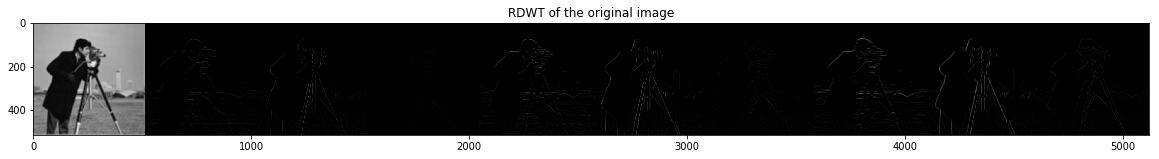

In [64]:
plt.figure(figsize=(20,10))
plt.imshow(WT(y0), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('RDWT of the original image')
plt.show()

In [51]:
# gradient
def grad(p, A, AT, y, lam, q1, q2, t):

    x = p[:,:,0]
    u = p[:,:,1]

    grad = np.zeros(p.shape)
    grad[:,:,0] = t*2*(AT(A(x)) - AT(y)) - (q1 - q2)
    grad[:,:,1] = t*lam - (q1 + q2)

    return grad

# Hessian-vector product
def Hvec(p, A, AT, d1, d2, t):

    x = p[:,:,0]
    u = p[:,:,1]

    r = np.zeros(p.shape)
    r[:,:,0] = t*2*AT(A(x)) + d1*x + d2*u
    r[:,:,1] = d2*x + d1*u

    return r

# Preconditioner-vector product
def Mvec(p, d1, d2, d3, t):

    x = p[:,:,0]
    u = p[:,:,1]

    r = np.zeros(p.shape)
    r[:,:,0] = (d1*x - d2*u)/(d1*d3 - d2**2)
    r[:,:,1] = (-d2*x + d3*u)/(d1*d3 - d2**2)

    return r

In [52]:
# Preconditioned conjugate gradient method
def pcg(A, b, x0, n_iter=None, M=None):
    if M==None:
        M = lambda v: v
    x = x0.copy()
    r = b - A(x)
    z = M(r)
    p = z
    rsold = np.sum(r*z);
    if n_iter==None:
        n_iter = np.size(b)
    for i in range(n_iter):
        Ap = A(p)
        alpha = rsold / np.sum(p*Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        z = M(r)
        rsnew = np.sum(r*z)
        if np.sqrt(rsnew) < 1e-10:
              break
        p = z + (rsnew / rsold) * p
        rsold = rsnew
    return x

In [53]:
# Backtracking line search
def linesearch(xu, dxu, A, y, lam, t, grad):

    gdx = np.sum(grad*dxu)

    dx = dxu[:,:,0]
    du = dxu[:,:,1]

    x = xu[:,:,0]
    u = xu[:,:,1]

    z = A(x) - y
    f = t*np.sum(z*z) + t*lam*np.sum(u) - np.sum(np.log(u+x+1e-12)) - np.sum(np.log(u-x+1e-12))

    s = 1.0
    for lsiter in range(100):
        newx = x + s*dx 
        newu = u + s*du
        constraints = np.concatenate((newx-newu, -newx-newu), axis=1).flatten()
        if (max(constraints) < 0):
            newz =  A(newx) - y
            newf = t*np.sum(newz*newz) + t*lam*np.sum(newu) - np.sum(np.log(newu+newx+1e-12)) - np.sum(np.log(newu-newx+1e-12))
            if (newf-f <= 0.01*s*gdx):
                break;
        s = 0.5*s;       
    r = np.zeros(xu.shape)
    r[:,:,0] = newx;
    r[:,:,1] = newu;

    return r, s

In [59]:
def ls_l1_barrier_method(A, AT, y, lam, x0):

    max_outer_iter = 10
    max_inner_iter = 3

    tau = 1

    t = 10 #max(1,1/lam)
    s = np.inf
    gap = np.inf

    m,n = x0.shape
    xu = np.random.rand(m,n,2)
    xu[:,:,0] = x0
    xu[:,:,1] = np.sign(xu[:,:,0])*xu[:,:,0]*5.

    # start from feasible point
    assert(max(np.concatenate((xu[:,:,0]-xu[:,:,1],-xu[:,:,0]-xu[:,:,1]), axis=1).flatten()) < 0.)

    # outer loop
    for k in range(max_outer_iter):        
        # inner loop
        for it in range(max_inner_iter):

            x = xu[:,:,0]
            u = xu[:,:,1]
            q1 = 1./(u+x)
            q2 = 1./(u-x)
            d1 = (q1**2 + q2**2)
            d2 = (q1**2 - q2**2)
            d3 = 2*t*tau + d1

            Hv = lambda v: Hvec(v, A, AT, d1, d2, t)
            Mv = lambda v: Mvec(v, d1, d2, d3, t)

            #find search direction via PCG
            g = grad(xu, A, AT, y, lam, q1, q2, t)
            dxu = pcg(Hv, -g, xu, 50, Mv)

            xu, s = linesearch(xu, dxu, A, y, lam, t, g)

            f = norm(A(xu[:,:,0]) - y, 'fro')**2 + lam*np.sum(np.abs(xu[:,:,0]))
            print("%2d:%2d, f=%15.2f" % (k, it, f))

        if np.size(x0)/t < 1e-10:
            break
        else:
            t = t*2.

    return xu[:,:,0]

In [67]:
H_FFT = fft2(h)
HC_FFT = np.conj(H_FFT)

#B = lambda v: convolve2d(v, kernel, mode='same', boundary='wrap')
B =  lambda v: np.real(ifft2(H_FFT*fft2(v)))
BT = lambda v: np.real(ifft2(HC_FFT*fft2(v)))

A = lambda v: B(W(v))
AT = lambda v: WT(BT(v))

First, let's start from solving $l_2$-regularized problem:

${x} = \underset{{x}}{\mathrm{argmin}} \: \|{Ax} - {y}\|^2 + \lambda\|{x}\|^2_2$

It has the analytic solution:

$x = (A^TA + \lambda I)^{-1} A^Ty$

In [68]:
lam = 0.001 # best lambda

x0 = WT(y) 

start = time.time()
x_sol = pcg(lambda v: AT(A(v)) + lam*v, AT(y), x0, n_iter=200)
end = time.time()

print("Elapsed time, (sec): %d" % (int(end - start)))

mse = norm(y0 - W(x_sol),'fro')**2 /(M*N)
ISNR = 10.*np.log10(norm(y-y0,'fro')**2 / (mse*M*N) )

print("MSE: %0.2f, ISNR: %0.2f dB" % (mse, ISNR))

Elapsed time, (sec): 30
MSE: 54.40, ISNR: 6.60 dB


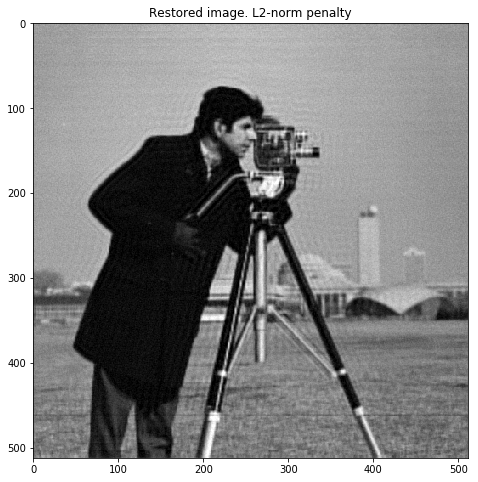

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(W(x_sol), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored image. L2-norm penalty')
plt.show()

In [70]:
lmbda = 0.01 # best lambda

x0 = WT(y) 

start = time.time()
x_sol = ls_l1_barrier_method(A, AT, y, lmbda, x0)
end = time.time()

print("Elapsed time, (sec): %d" % (int(end - start)))

mse = norm(y0 - W(x_sol),'fro')**2 /(M*N)
ISNR = 10.*np.log10(norm(y-y0,'fro')**2 / (mse*M*N) )

print("MSE: %0.2f, ISNR: %0.2f dB" % (mse, ISNR))

 0: 0, f=     5324917.28
 0: 1, f=     5022879.92
 0: 2, f=     4464921.79
 1: 0, f=     3973509.54
 1: 1, f=     3137685.47
 1: 2, f=     1942487.54
 2: 0, f=     1579956.30
 2: 1, f=     1302428.34
 2: 2, f=      906166.30
 3: 0, f=      843897.42
 3: 1, f=      737994.05
 3: 2, f=      656754.23
 4: 0, f=      624234.28
 4: 1, f=      595618.81
 4: 2, f=      570431.40
 5: 0, f=      559028.06
 5: 1, f=      537970.66
 5: 2, f=      528563.50
 6: 0, f=      524038.87
 6: 1, f=      515345.81
 6: 2, f=      507202.64
 7: 0, f=      503278.96
 7: 1, f=      495755.23
 7: 2, f=      493981.72
 8: 0, f=      492191.15
 8: 1, f=      488690.48
 8: 2, f=      485323.75
 9: 0, f=      484481.67
 9: 1, f=      481172.29
 9: 2, f=      479588.63
Elapsed time, (sec): 594
MSE: 38.13, ISNR: 8.14 dB


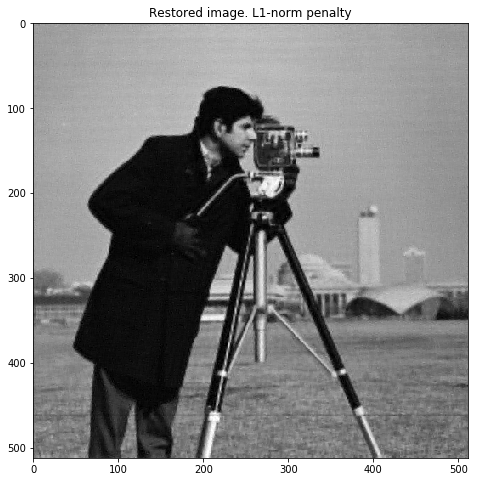

In [72]:
plt.figure(figsize=(8,8))
plt.imshow(W(x_sol), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored image. L1-norm penalty')
plt.show()

Illustration of why $l_1$-norm penalty leads to sparse solutions:

<img src="https://tianyizhou.files.wordpress.com/2010/08/l1l2.jpg" width=500>
[Sourse: https://tianyizhou.wordpress.com/]